### Задача 3.3
Предложить метод выбора наиболее важных признаков для логистической регрессии на основе изученных методов прикладной статистики. Осуществить выбор.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.datasets import load_wine

import statsmodels.api as sm

from statsmodels.formula.api import ols

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from statsmodels.stats.weightstats  import ttest_ind

In [12]:
wine = load_wine()

featute_cols = wine['feature_names']
featute_cols = list(map(lambda x: x.replace('od280/od315_of_diluted_wines', 'od280'), featute_cols)) # rename column
X_wine = pd.DataFrame(wine['data'], columns =  featute_cols)
y_wine = wine['target']

df_wine = X_wine
df_wine['target'] = y_wine
# df_wine.rename(columns = {'od280/od315_of_diluted_wines':'od280'}, inplace=True)
df_wine.sample(10).sort_index()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280,proline,target
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0,0
46,14.38,3.59,2.28,16.0,102.0,3.25,3.17,0.27,2.19,4.90,1.04,3.44,1065.0,0
64,12.17,1.45,2.53,19.0,104.0,1.89,1.75,0.45,1.03,2.95,1.45,2.23,355.0,1
80,12.00,0.92,2.00,19.0,86.0,2.42,2.26,0.30,1.43,2.50,1.38,3.12,278.0,1
92,12.69,1.53,2.26,20.7,80.0,1.38,1.46,0.58,1.62,3.05,0.96,2.06,495.0,1
109,11.61,1.35,2.70,20.0,94.0,2.74,2.92,0.29,2.49,2.65,0.96,3.26,680.0,1
122,12.42,4.43,2.73,26.5,102.0,2.20,2.13,0.43,1.71,2.08,0.92,3.12,365.0,1
151,12.79,2.67,2.48,22.0,112.0,1.48,1.36,0.24,1.26,10.80,0.48,1.47,480.0,2
162,12.85,3.27,2.58,22.0,106.0,1.65,0.60,0.60,0.96,5.58,0.87,2.11,570.0,2
168,13.58,2.58,2.69,24.5,105.0,1.55,0.84,0.39,1.54,8.66,0.74,1.80,750.0,2


Оценим визуально попарную корреляцию признаков между собой и с целевой переменной

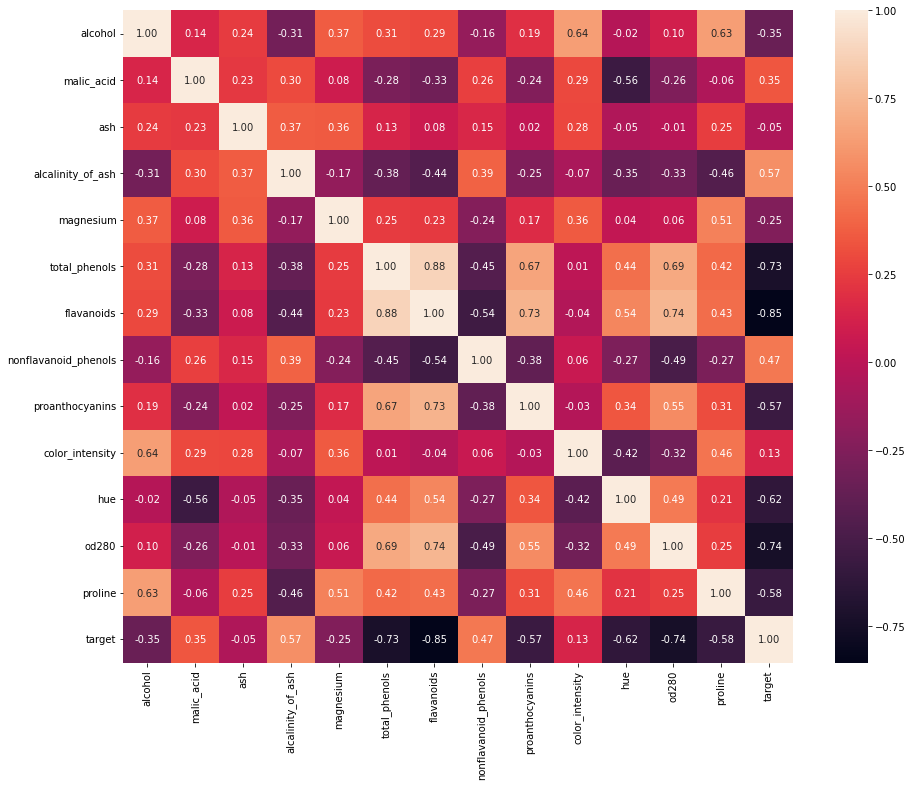

In [3]:
plt.figure(figsize = (15, 12))
_ = sns.heatmap(df_wine.corr(method = 'spearman'), annot=True, fmt = '.2f')

Самый наивный вариант: посмотреть на корреляцию признаков с целевой переменной и на корреляцию признаков между собой.

Если какой-то признак сильно коррелирует с другим, но при этом слабо с целовой переменной, то такой признак можно удалять. 

В данном случае очевидных кандидатов на отсеивание таким способом нет, так как признаки, сильно коррелирующие между собой, также сильно коррелируют с целевой переменной. 

In [15]:
sorted_features = list(df_wine.corr()['target'].abs().sort_values(ascending = False).iloc[1:].index)
sorted_features

['flavanoids',
 'od280',
 'total_phenols',
 'proline',
 'hue',
 'alcalinity_of_ash',
 'proanthocyanins',
 'nonflavanoid_phenols',
 'malic_acid',
 'alcohol',
 'color_intensity',
 'magnesium',
 'ash']

В случае, когда целевая переменная является категориальной, а признаки являются числовыми, имеет смысл применять дисперсионный анализ (ANOVA). То есть отбираем признаки критерием Фишера

Сначала посмотрим без межфакторного взаимодействия для всех признаков

In [128]:
y.value_counts()

1    71
0    59
2    48
Name: target, dtype: int64

In [129]:
lm = ols('target ~ flavanoids + \
                   od280 + \
                   total_phenols + \
                   proline + \
                   hue + \
                   alcalinity_of_ash + \
                   proanthocyanins + \
                   color_intensity + \
                   nonflavanoid_phenols + \
                   malic_acid + \
                   alcohol + \
                   magnesium + \
                   ash',
         data=df_wine).fit()

result = sm.stats.anova_lm(lm, typ=2) # data slightly unbalanced => better use typ=2
# result[result['PR(>F)'] < 0.05].sort_values(by='PR(>F)')
result

,sum_sq,df,F,PR(>F)
flavanoids,3.483899,1.0,53.787275,9.736855e-12
od280,1.718937,1.0,26.538353,7.339233e-07
total_phenols,0.333141,1.0,5.143305,2.464123e-02
proline,3.055666,1.0,47.175867,1.279426e-10
hue,0.080729,1.0,1.246364,2.658810e-01
alcalinity_of_ash,1.400560,1.0,21.622994,6.793864e-06
proanthocyanins,0.045460,1.0,0.701844,4.033841e-01
color_intensity,1.797680,1.0,27.754062,4.279710e-07
nonflavanoid_phenols,0.140550,1.0,2.169932,1.426491e-01
malic_acid,0.121379,1.0,1.873943,1.728962e-01


In [103]:
result[result['PR(>F)'] < 0.05].sort_values(by='PR(>F)')

,sum_sq,df,F,PR(>F)
flavanoids,3.483899,1.0,53.787275,9.736855e-12
proline,3.055666,1.0,47.175867,1.279426e-10
color_intensity,1.797680,1.0,27.754062,4.279710e-07
od280,1.718937,1.0,26.538353,7.339233e-07
alcalinity_of_ash,1.400560,1.0,21.622994,6.793864e-06
alcohol,0.649082,1.0,10.021053,1.845335e-03
total_phenols,0.333141,1.0,5.143305,2.464123e-02


Посмотрим на и межфакторное взаимодействие для этих признаков

In [131]:
important_features_my = ['flavanoids', 'proline', 'od280', 'alcalinity_of_ash', 'color_intensity', 'alcohol']

lm = ols('target ~ flavanoids * \
                   od280 * \
                   proline * \
                   color_intensity * \
                   alcohol * \
                   alcalinity_of_ash',
         data=df_wine).fit()

result_imp = sm.stats.anova_lm(lm, typ=2)
result_imp[result_imp['PR(>F)'] < 0.05].sort_values(by='PR(>F)')

,sum_sq,df,F,PR(>F)
flavanoids,2.422594,1.0,73.656660,5.392928e-14
proline,1.252025,1.0,38.066628,1.072373e-08
color_intensity,0.585241,1.0,17.793690,4.960892e-05
flavanoids:od280,0.570458,1.0,17.344224,6.087568e-05
od280,0.558581,1.0,16.983114,7.180436e-05
flavanoids:alcohol,0.420472,1.0,12.784062,5.140076e-04
flavanoids:od280:color_intensity:alcohol,0.317620,1.0,9.656931,2.381669e-03
flavanoids:od280:proline:alcohol,0.308649,1.0,9.384167,2.731463e-03
alcohol,0.264372,1.0,8.037991,5.420641e-03
alcalinity_of_ash,0.202352,1.0,6.152320,1.458482e-02


Ну в общем то на этом можно было бы и завершить поиск наиболее важных признаков)) Приведём шесть из них:

* flavanoids
* proline
* od280
* alcalinity_of_ash
* color_intensity
* alcohol

Посмотрим на реализацию аналогичного отбора признаков из sklearn 

In [135]:
from sklearn.feature_selection import f_classif
X = df_wine[featute_cols]
y = df_wine['target']

In [136]:
from sklearn.feature_selection import SelectKBest

fs = SelectKBest(score_func=f_classif, k=6)
X_selected = fs.fit_transform(X, y)

In [137]:
selector = SelectKBest(f_classif, k=6)
selector.fit(X, y)
cols = selector.get_support(indices=True)
features_df_new = X.iloc[:,cols]
list(features_df_new.columns)

['alcohol', 'flavanoids', 'color_intensity', 'hue', 'od280', 'proline']

Попробуем другой метод (mutual_info_classif)

In [138]:
from sklearn.feature_selection import mutual_info_classif
selector = SelectKBest(score_func=mutual_info_classif, k=6)
selector.fit(X, y)
cols = selector.get_support(indices=True)
features_df_new = X.iloc[:,cols]
list(features_df_new.columns)

['alcohol', 'flavanoids', 'color_intensity', 'hue', 'od280', 'proline']

Было бы разумно протестировать модель с выбранными признаками и сравнить её с моделью, обученной на всём датасете. 

In [139]:
from sklearn import svm, datasets
from sklearn.model_selection import cross_val_score

important_features_my = ['flavanoids', 'proline', 'od280', 'alcalinity_of_ash', 'color_intensity', 'alcohol']
important_features_sk = ['alcohol', 'flavanoids', 'color_intensity', 'hue', 'od280', 'proline']

X = df_wine[featute_cols].to_numpy()
y = df_wine['target'] 

X_scaled = StandardScaler().fit_transform(X)

np.mean(cross_val_score(LogisticRegression(), X_scaled, y, cv=5, scoring='f1_weighted'))

0.9889476778365667

In [140]:
X_if = df_wine[important_features_sk].to_numpy()

X_if_scaled = StandardScaler().fit_transform(X_if)

np.mean(cross_val_score(LogisticRegression(), X_if_scaled, y, cv=5, scoring='f1_weighted'))

0.988872131835317

Отбор 6 признаков встроенным в sklearn методом позволяет добиться такого же качества, как и у оригинальной модели. 

In [141]:
X_if = df_wine[important_features_my].to_numpy()

X_if_scaled = StandardScaler().fit_transform(X_if)

np.mean(cross_val_score(LogisticRegression(), X_if_scaled, y, cv=5, scoring='f1_weighted'))

0.9542427213521666

Как видно, в качестве по метрике f1 мы достаточно много потеряли (но всё же мы выкинули половину признаков, а их и так не много было)

Как видно, выбранный моим методом признак color_intensity только ухудшает качество классификации...